<a href="https://colab.research.google.com/github/Flaviofrc97/DATA-SCIENSE-PROJECTS/blob/main/spaceship_titanic_predict_ipynb_txt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as ss

from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings( 'ignore' )

plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (15,7)

# File and Data Field Descriptions

**train.csv** - Personal records for about two-thirds (~8700) of the passengers, to be used as training data.

**PassengerId** - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.

**HomePlanet** - The planet the passenger departed from, typically their planet of permanent residence.

**CryoSleep** - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.

**Cabin** - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.

**Destination** - The planet the passenger will be debarking to.

**Age** - The age of the passenger.

**VIP** - Whether the passenger has paid for special VIP service during the voyage.

**RoomService, FoodCourt, ShoppingMall, Spa, VRDeck** - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.

**Name** - The first and last names of the passenger.

**Transported** - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

train = "/content/drive/MyDrive/Datasests/SPACE/train.csv"
test = "/content/drive/MyDrive/Datasests/SPACE/test.csv"
sub="/content/drive/MyDrive/Datasests/SPACE/sample_submission.csv"

In [ ]:
train = pd.read_csv(train)
test = pd.read_csv(test)
sub = pd.read_csv(sub)

train['Transported'] = train['Transported'].astype(int)

In [ ]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,0
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,1
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,0
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,0
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,1


In [ ]:
train.shape, test.shape

((8693, 14), (4277, 13))

In [ ]:
train.isna().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

# Feature Engeeneing

In [ ]:
TARGET = train[['Transported']]
train1 = train.copy()
test1 = test.copy()

In [ ]:
def fill_cat(df: pd.DataFrame):
    col_feat = list(train1.select_dtypes(exclude=['int64', 'float64']).columns)
    col_feat.remove('PassengerId')
    for col in col_feat:
        df[col].fillna(df[col].mode()[0], inplace=True)
    return df
        
def fill_num(df: pd.DataFrame):
    col_feat = list(train1.select_dtypes(include=['int64', 'float64']).columns)
    col_feat.remove('Transported')
    for col in col_feat:
        df[col].fillna(df[col].median(), inplace=True)
    return df
        
def convert_bainary(df: pd.DataFrame):
    cols = ['VIP','CryoSleep']
    for col in cols:
        df[col] = df[col].astype(int)
    return df

#off
def log_transform(df: pd.DataFrame):
    col_feat = ['Age','RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck' ]
    for col in col_feat:
        df[col] = np.log(df[col])
    return df

In [ ]:
def create_columns(df: pd.DataFrame):
    df['deck'] = df['Cabin'].apply(lambda x: x.split('/')[0])
    df['num'] = df['Cabin'].apply(lambda x: x.split('/')[1])
    df['side'] = df['Cabin'].apply(lambda x: x.split('/')[2])
    df['LastName'] = df.Name.str.split(' ').str[1]
    df['group'] = df['PassengerId'].apply(lambda x: x[0:4])
    df['vr_spend']=df['RoomService']+df['FoodCourt']+df['ShoppingMall']+df['Spa']+df['VRDeck']
    df['familyCounts'] = df.groupby(['LastName'])['LastName'].transform('count')
    return df

def drop_cols(df: pd.DataFrame):
    df.drop('Name', axis=1, inplace=True)
    return df


def reduce_cardinality(df: pd.DataFrame ):
    col_ = ['Cabin', 'deck','num', 'side']
    for col in col_:
        #get a list of categories which contain one value
        tmp=list(df[col].value_counts()[df[col].value_counts()<2].index)
        #Replace with 'other'
        df[col]=df[col].apply(lambda x:'other' if x in tmp else x)
    return df

In [ ]:
%%time
train1 = (train1.pipe(fill_cat).pipe(fill_num).pipe(convert_bainary))
test1 = (test1.pipe(fill_cat).pipe(fill_num).pipe(convert_bainary))

train1 = (train1.pipe(create_columns).pipe(drop_cols))
test1 = (test1.pipe(create_columns).pipe(drop_cols))

CPU times: user 98.8 ms, sys: 3.64 ms, total: 102 ms
Wall time: 102 ms


## EDA

In [ ]:
cats = list(train1.select_dtypes(exclude=['int64', 'float64']).columns)
cats.remove('PassengerId')
for i in cats:
    print(i)
    le=LabelEncoder()
    arr=np.concatenate((train1[i], test1[i])).astype(str)
    le.fit(arr)
    train1[i]=le.transform(train1[i].astype(str))
    test1[i]=le.transform(test1[i].astype(str))

HomePlanet
Cabin
Destination
deck
num
side
LastName
group


In [ ]:
train1.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,deck,num,side,LastName,group,vr_spend,familyCounts
0,0001_01,1,0,208,2,39.0,0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,1551,0,0.0,1
1,0002_01,0,0,3241,2,24.0,0,109.0,9.0,25.0,549.0,44.0,1,5,0,1,2289,1,736.0,4
2,0003_01,1,0,1,2,58.0,1,43.0,3576.0,0.0,6715.0,49.0,0,0,0,1,2153,2,10383.0,6
3,0003_02,1,0,1,2,33.0,0,0.0,1283.0,371.0,3329.0,193.0,0,0,0,1,2153,2,5176.0,6
4,0004_01,0,0,3243,2,16.0,0,303.0,70.0,151.0,565.0,2.0,1,5,1,1,1924,3,1091.0,6


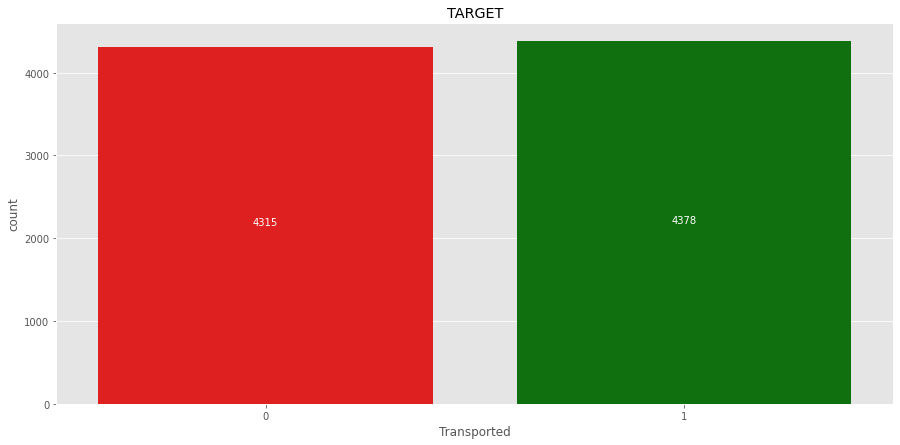

In [ ]:
g = sns.countplot(x = 'Transported', data = train , palette=['g' if c == True else 'r' for c in train['Transported']]);
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height/2,
            '{}'.format(round(height)),
            ha="center", color='white')
plt.title('TARGET');

**We have a balanced class**

## **Bivariate Analysis**

In [ ]:
cat_feat = train1.select_dtypes(include='object')
num_feat = train1.select_dtypes(exclude='object')
num_feat.drop('Transported', axis=1, inplace=True)

 ## **Numerical Variable**

In [ ]:
num_feat.describe()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,deck,num,side,LastName,group,vr_spend,familyCounts
count,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000
mean,0.649833,0.349362,4819.036466,1.494306,28.790291,0.022892,220.009318,448.434027,169.572300,304.588865,298.261820,4.344185,1011.745197,0.516162,1194.661452,4632.389624,1440.866329,10.226734
std,0.795183,0.476796,3032.501554,0.814966,14.341404,0.149568,660.519050,1595.790627,598.007164,1125.562559,1134.126417,1.775938,535.059773,0.499767,689.883384,2671.028856,2803.045694,30.867005
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,0.000000,1968.000000,1.000000,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,531.000000,0.000000,626.000000,2318.000000,0.000000,3.000000
50%,0.000000,0.000000,4815.000000,2.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,1084.000000,1.000000,1194.000000,4629.000000,716.000000,5.000000
75%,1.000000,1.000000,7563.000000,2.000000,37.000000,0.000000,41.000000,61.000000,22.000000,53.000000,40.000000,6.000000,1438.000000,1.000000,1770.000000,6882.000000,1441.000000,7.000000
max,2.000000,1.000000,9822.000000,2.000000,79.000000,1.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000,7.000000,1893.000000,1.000000,2405.000000,9279.000000,35987.000000,207.000000


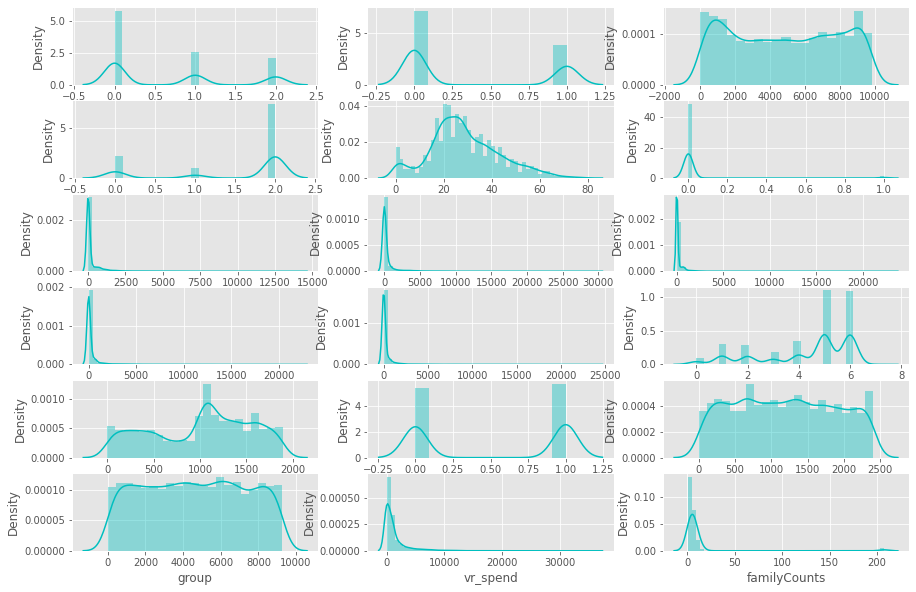

In [ ]:
plt.figure(figsize=(15,10));
for i, feat in enumerate(num_feat):
    plt.subplot( 6, 3, i + 1 );
    sns.distplot(x=num_feat[feat], color = 'c')
    plt.xlabel(feat);

**As we can see, the columns doesnt have a normal curve. So, after i will try use log to do a normalization.**

# **MULTIVARIETED ANALYSI**S

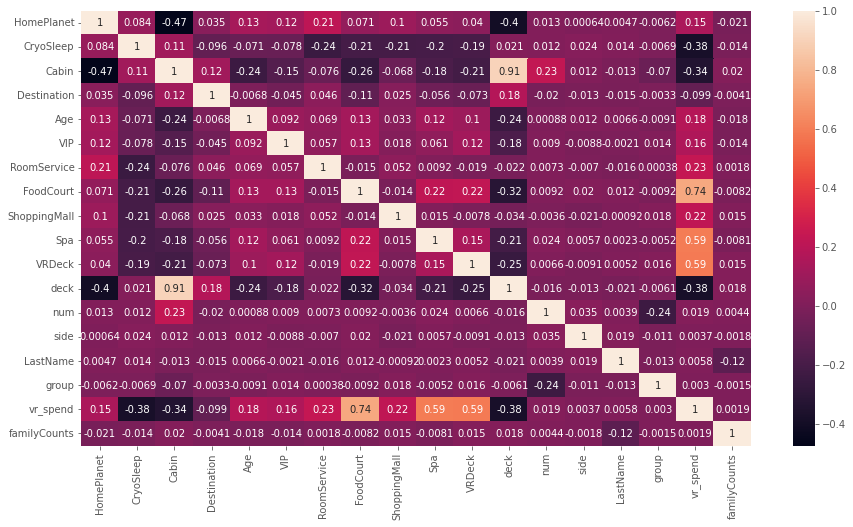

In [ ]:
plt.figure(figsize=(15,8));
num_corr = num_feat.corr();
sns.heatmap(num_corr, annot=True);

# **FEATUER ENGENEERING**

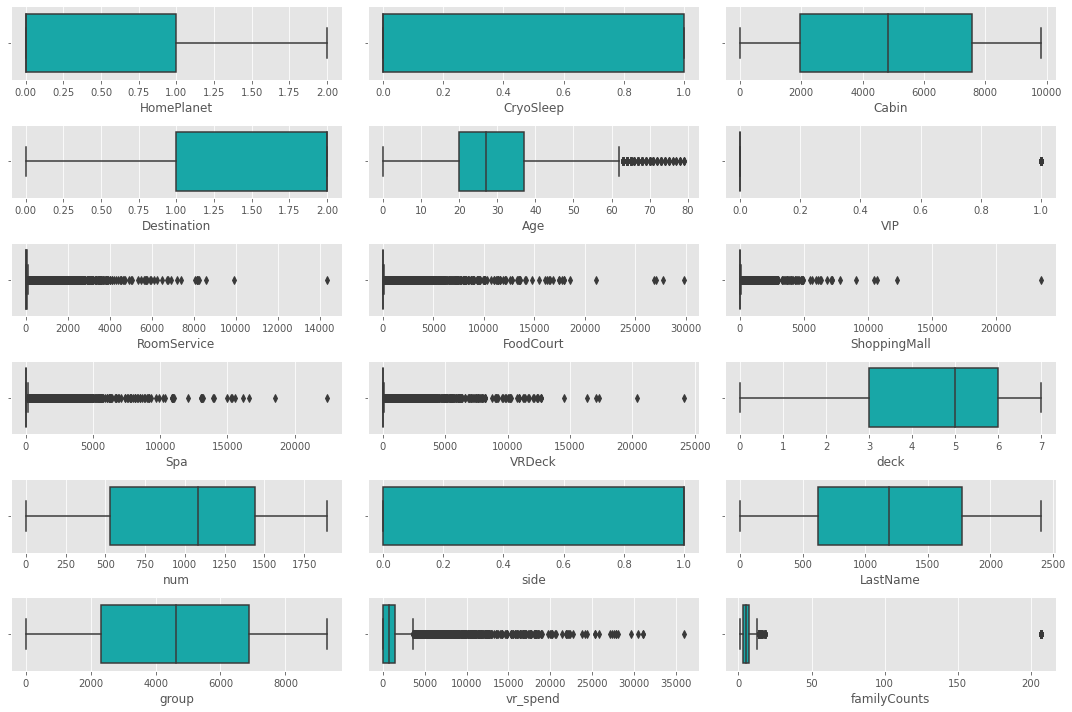

In [ ]:
plt.figure(figsize=(15,10));
for i, feat_num in enumerate(num_feat):
    plt.subplot( 6, 3, i + 1 );
    sns.boxplot(x=num_feat[feat_num], color = 'c')
    plt.xlabel(feat_num);
    plt.tight_layout()

**Okay Kaggle, I think you've overdone the outliers**

## **STANDARD SCALER**

In [ ]:
X = train1.drop(['PassengerId'],axis=1)
X_test1 = test1.drop('PassengerId', axis=1)
y = TARGET

In [ ]:
X.shape, X_test1.shape

((8693, 19), (4277, 18))

In [ ]:
cols = list(X.columns)
cols.remove('Transported')

In [ ]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X[cols] = sc.fit_transform(X[cols])
X_test1[cols] = sc.transform(X_test1[cols])

In [ ]:
!pip install h2o

     |████████████████████████████████| 176.2 MB 1.3 kB/s 
  Created wheel for h2o: filename=h2o-3.36.0.4-py2.py3-none-any.whl size=176245474 sha256=cdf823763b0595b390a7d10a8e63d82c9253810588d0e64d0bf89fcd61805ad8
  Stored in directory: /root/.cache/pip/wheels/66/7c/3b/6558f625a9415a96f7f650d33f1def07b6e30b0c871e8407a1
Successfully built h2o


In [ ]:

import h2o
from h2o.automl import H2OAutoML

# Start the H2O cluster (locally)
h2o.init()

train_h2o = h2o.H2OFrame(X)
test_h2o = h2o.H2OFrame(X_test1)

# Identify predictors and response
x = train_h2o.columns
y = "Transported"
train_h2o[y] = train_h2o[y].asfactor()
x.remove(y)

# Run AutoML for 10 base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(max_models=50, seed=24)
aml.train(x=x, y=y, training_frame=train_h2o)


ml_h2o = aml.predict(test_h2o)
preds_h2o = ml_h2o[0].as_data_frame().values.flatten()
preds_h2o

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.14" 2022-01-18; OpenJDK Runtime Environment (build 11.0.14+9-Ubuntu-0ubuntu2.18.04); OpenJDK 64-Bit Server VM (build 11.0.14+9-Ubuntu-0ubuntu2.18.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.7/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpyg_a_f8r
  JVM stdout: /tmp/tmpyg_a_f8r/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpyg_a_f8r/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.0.4
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_unknownUser_m73rtn
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,6.365 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |███████████████████████████████████████████████████████████████

## best result with 11 moldes

In [ ]:


submission = pd.DataFrame({
        "PassengerId": sub["PassengerId"],
        "Transported":  preds_h2o
    })

submission['Transported'] = submission['Transported'].astype('bool')
submission.to_csv('pred_h20_2o_ml.csv', index=False)
submission

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold, GroupKFold

In [ ]:
from lightgbm import LGBMClassifier


LGBM = LGBMClassifier()

In [ ]:
y_probs = []

In [ ]:
folds = StratifiedKFold(n_splits = 10, shuffle=True, random_state=24)
for fold, (train_id, test_id) in enumerate(folds.split(X, y)):
   print("fold : ", fold + 1, end = ' ')
# Split data
   X_train = X.iloc[train_id]
   y_train = y.iloc[train_id]
   X_valid = X.iloc[test_id]
   y_valid = y.iloc[test_id]

# Train RF
   model = LGBMClassifier(max_depth=5, n_estimators=100)
   model.fit(X_train, y_train)

# Print validation score to see how it works
   valid_pred = model.predict(X_valid)
   valid_score = accuracy_score(y_valid, valid_pred)
   print( "Validation score: ", valid_score, end = ' ')

# test
   y_preds = model.predict_proba(X_test1)
   df = pd.DataFrame({"Name": [fold], "values": [y_preds.data]})
   y_probs.append(model.predict_proba(X_test1))
   print(" ")
   pred_test_full = 0
   pred_test = model.predict_proba(X_test1)[:,1]
   pred_test_full +=pred_test 
   i+=1